In [1]:
import numpy as np
from scipy.special import rel_entr

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
%config InlineBackend.figure_format='retina'


### Cross Entropy

In [2]:
def cross_entropy(p, q):
    return -np.sum(p * np.log(q))

Note that the two distributions below have the _same_ cross entropy!

In [17]:
color1 = '#6138ba'
color2 = 'pink'

1.0


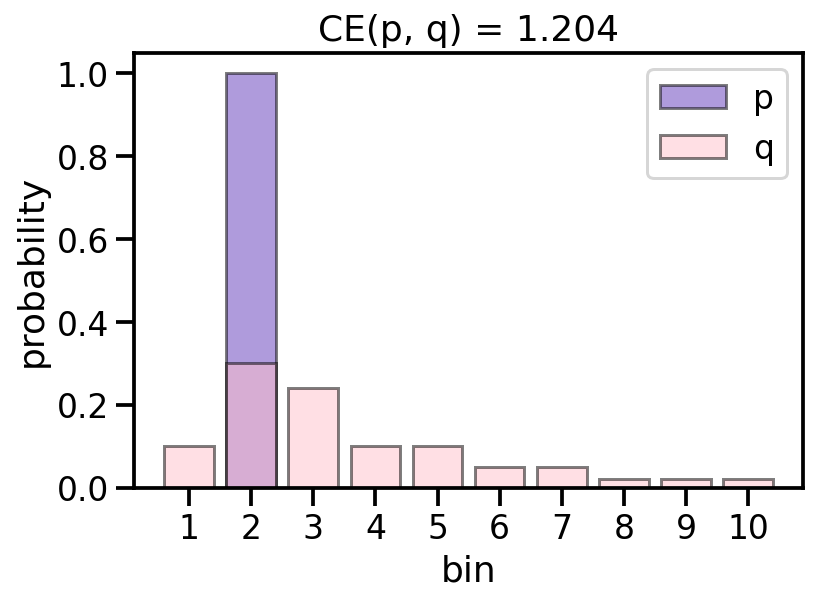

In [273]:
p = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
q1 = np.array([0.1, 0.3, 0.24, 0.1, 0.1, 0.05, 0.05, 0.02, 0.02, 0.02])

assert len(p) == len(q1)
assert np.sum(p) == 1
assert np.sum(q1) == 1

print(sum(q1))

x = np.arange(1, len(p) + 1)

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q1, alpha=0.5, label='q', color=color2, edgecolor='black')

ce = round(cross_entropy(p, q1), 4)
plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'CE(p, q) = {ce}')
plt.legend();

1.0


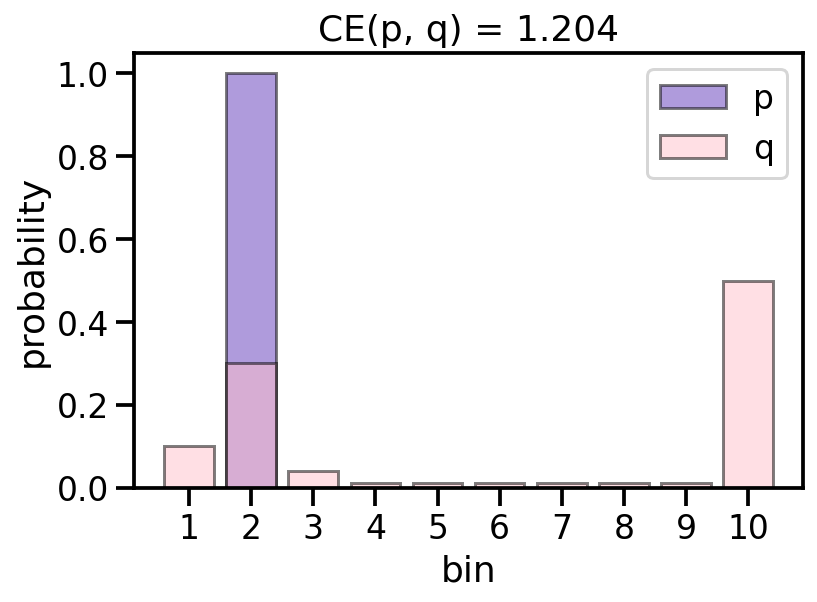

In [79]:
p = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
q2 = np.array([0.1, 0.3, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.5])

assert len(p) == len(q2)
assert np.sum(p) == 1
assert np.sum(q2) == 1

print(sum(q2))


plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q2, alpha=0.5, label='q', color=color2, edgecolor='black')

ce = round(cross_entropy(p, q2), 4)
plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'CE(p, q) = {ce}')
plt.legend();

Cross entropy scales _entirely_ as a function of the probability our predicted distribution assigns to the true bin.

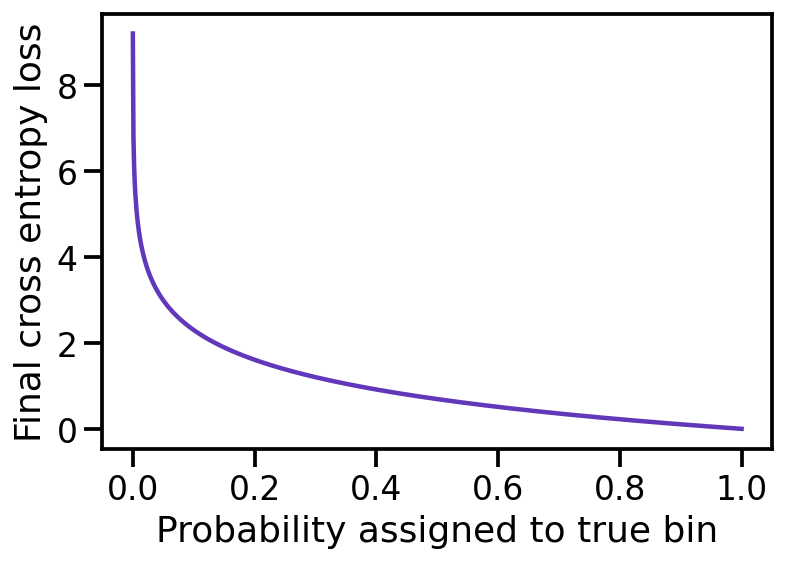

In [95]:
p = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
q_og = np.array([0.1, 0.3, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.5])
update_to_q = np.linspace(0.0001, 1, 1000)

y = []
for i in update_to_q:
    q_og[1] = i
    y.append(cross_entropy(p, q_og))

plt.plot(update_to_q, y, color=color1)
plt.xlabel('Probability assigned to true bin')
plt.ylabel('Final cross entropy loss')
plt.show()

It is worth asking - is this non linearity really what we want? For instance, from our perspective, is it really that much worse to predict a probability of 0.01 compared to 0.001? They are both terrible predictions! In some contexts we would want them to be penalized almost equally. 

### Wasserstein Loss

In [96]:
import tensorflow as tf
import pandas as pd
from sklearn.metrics import pairwise_distances


def create_D(bins):
    """Create distance matrix between bins"""

	# Currently using index instead of middle of bin. Investigate.
    bin_mid = [i for i, x in enumerate(bins)]
	# bin_mid = [x.mid for x in bins]

    bin_mid_array = np.array(bin_mid)
    D = pd.DataFrame(
	    pairwise_distances(bin_mid_array.reshape(-1, 1))
    )
    D = D.values

    return D


D = create_D(q_og)


def ws_loss(y_true, y_pred, D):
    """Working implementation of WS loss"""
    p = y_true
    q = y_pred

    idx_of_true_class = np.where(p == 1)[0][0]

    distance_of_classes_to_true_class = D[idx_of_true_class, :]
    return sum(q * distance_of_classes_to_true_class), q * distance_of_classes_to_true_class

In [97]:
l, l_vals = ws_loss(p, q_og, D)
l

4.41

In [27]:
l, l_vals = ws_loss(p, q1, D)
l, l_vals

(1.7100000000000002,
 array([0.1 , 0.  , 0.24, 0.2 , 0.3 , 0.2 , 0.25, 0.12, 0.14, 0.16]))

In [28]:
l, l_vals = ws_loss(p, q2, D)
l, l_vals

(4.41, array([0.1 , 0.  , 0.04, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 4.  ]))

In [29]:
print(q1)
print(q2)

[0.1  0.3  0.24 0.1  0.1  0.05 0.05 0.02 0.02 0.02]
[0.1  0.3  0.04 0.01 0.01 0.01 0.01 0.01 0.01 0.5 ]


In [30]:
q3 = np.array([0.1, 0.3, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.11, 0.4])
assert sum(q3) == 1

l, l_vals = ws_loss(p, q3, D)
l, l_vals

(4.3100000000000005,
 array([0.1 , 0.  , 0.04, 0.02, 0.03, 0.04, 0.05, 0.06, 0.77, 3.2 ]))

At the end of the day, we can think about the this problem of loss as a way to _weighting_ each probability mass that we predict will be a in a bin.

Cross entropy places _all_ weight on the mass assigned to the _true bin_. 

Wasserstein places _no_ weight on the mass assigned to the true bin (since the probability mass predicted on that bin will have a distance of 0 to that bin), and all weight on the incorrect bins. The more weight assigned to those incorrect bins, the more loss. However, wasserstein 



### How does wasserstein change as we move mass from right most bin?

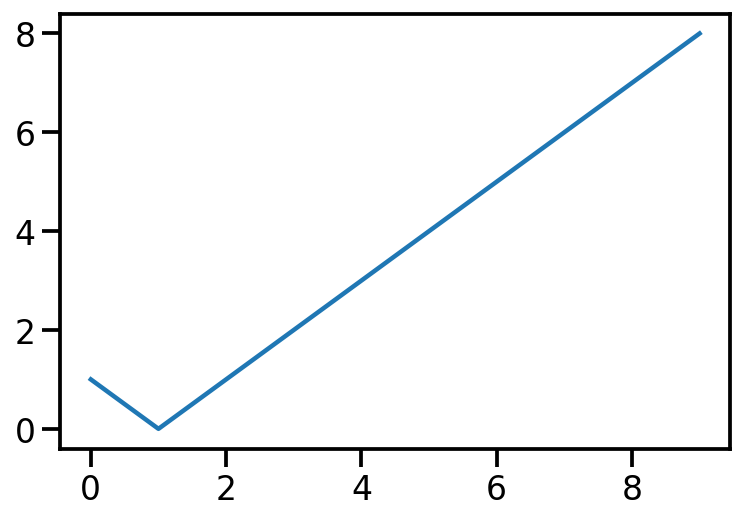

In [31]:
D = create_D(q_og)

plt.plot(D[1,:]);

1.0


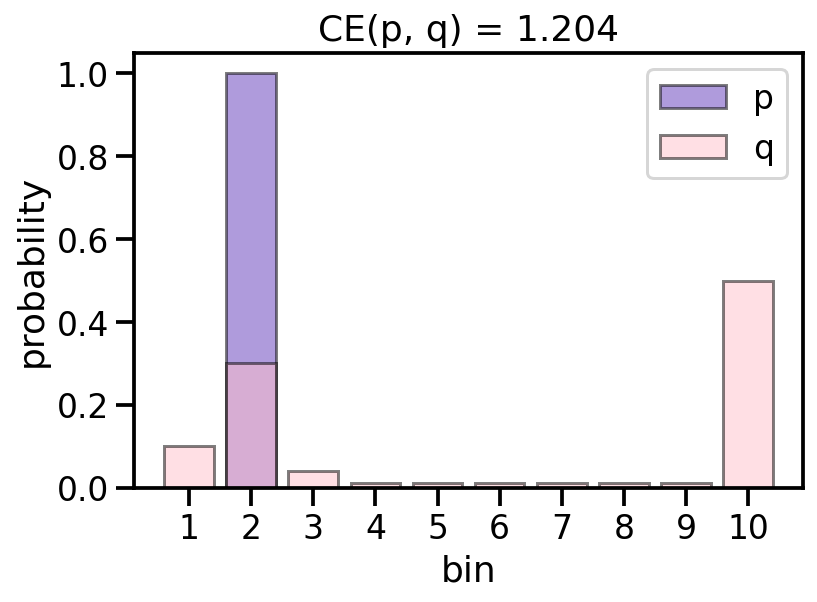

In [57]:
p = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
q_og = np.array([0.1, 0.3, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.5])

assert len(p) == len(q_og)
assert np.sum(p) == 1
assert np.sum(q_og) == 1

print(sum(q_og))


plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q_og, alpha=0.5, label='q', color=color2, edgecolor='black')

ce = round(cross_entropy(p, q_og), 4)
plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'CE(p, q) = {ce}')
plt.legend();

In [50]:
q_og[-1] - q_og[-9]

-0.2

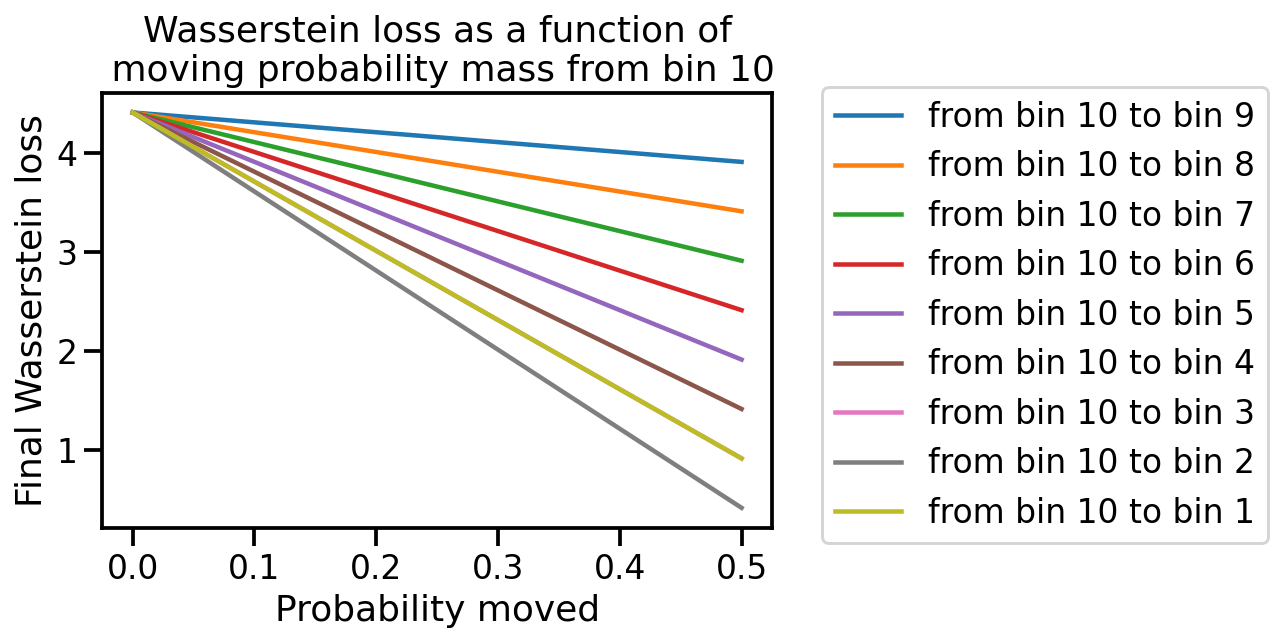

In [51]:
for b in [-2, -3, -4, -5, -6, -7, -8, -9, -10]:

    q_og = np.array([0.1, 0.3, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.5])

    # Move mass from bin 10 (right most) to bin -b (e.g. bin 8)
    amount_of_mass_to_move = q_og[-1] #- q_og[b]
    update_to_q_right_most_bin = np.linspace(0.0001, amount_of_mass_to_move, 100)

    # Move mass from right most bin to bin b
    y = []
    for i in update_to_q_right_most_bin:
        q_og = np.array([0.1, 0.3, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.5])
        q_og[-1] -= i
        q_og[b] += i
        assert np.isclose(sum(q_og), 1)
        res, _ = ws_loss(p, q_og, D)
        y.append(res)

    plt.plot(update_to_q_right_most_bin, y, label=f'from bin 10 to bin {10 + b + 1}')
    # break
plt.xlabel('Probability moved')
plt.ylabel('Final Wasserstein loss')
plt.title('Wasserstein loss as a function of\n moving probability mass from bin 10')
plt.legend(bbox_to_anchor=(1.05, 1.05))

plt.show()

So we can see that as we move mass from the right most bin, the _closer_ we move the mass to the true bin, the _more_ we reduce our loss. 

The questions remaining are:
* What are we missing by not having the nonlinearity associated with the cross entropy?
* What type of regularization was Tom talking about?

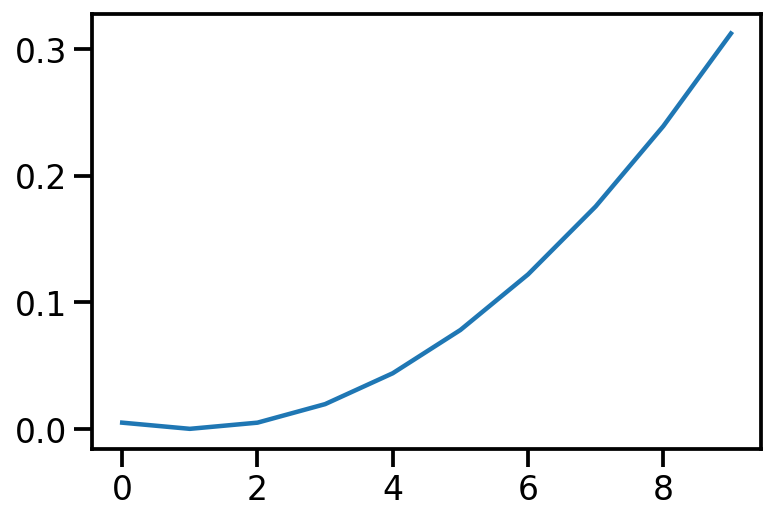

In [228]:
D = create_D(q)

D = (D ** 2) * (D ** 2).sum(axis=1, keepdims=True) ** -1

plt.plot(D[1,:]);

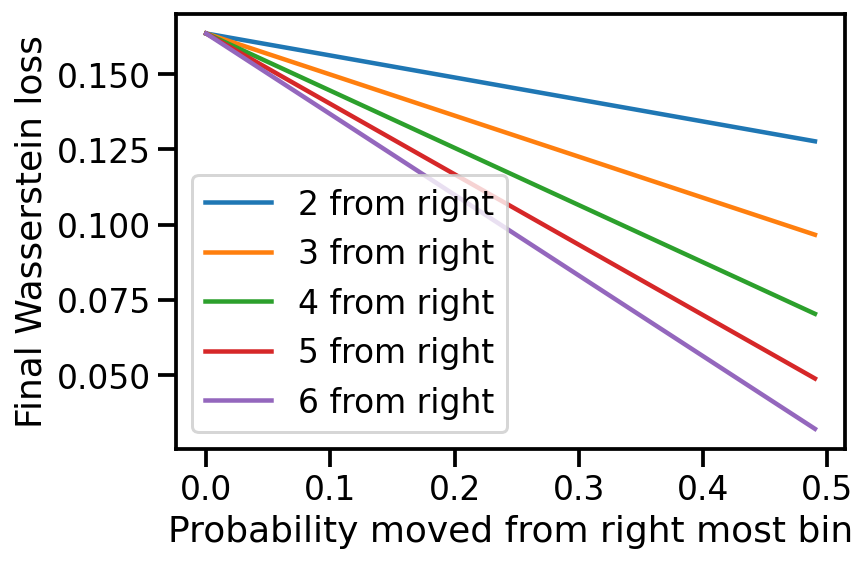

In [229]:
for b in [-2, -3, -4, -5, -6]:

    q_og = np.array([0.1, 0.3, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.5])
    amount_of_mass_to_move = q_og[-1] - q_og[b]
    update_to_q_right_most_bin = np.linspace(0.0001, amount_of_mass_to_move, 100)

    # Move mass from right most bin to bin b
    y = []
    for i in update_to_q_right_most_bin:
        q_og = np.array([0.1, 0.3, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.5])
        q_og[-1] -= i
        q_og[b] += i
        assert np.isclose(sum(q_og), 1)
        res, _ = ws_loss(p, q_og, D)
        y.append(res)

    plt.plot(update_to_q_right_most_bin, y, label=f'{np.abs(b)} from right')
    # break
plt.xlabel('Probability moved from right most bin')
plt.ylabel('Final Wasserstein loss')
plt.legend()

plt.show()

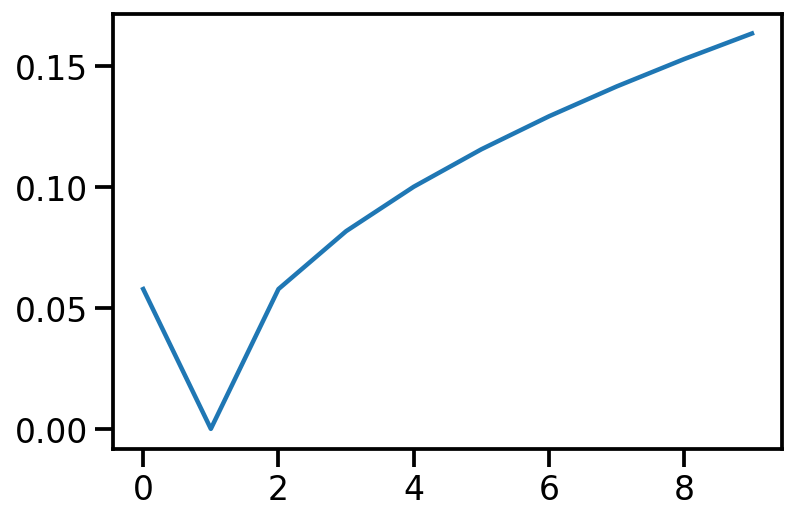

In [230]:
D = create_D(q)

D = (D ** 0.5) * (D ** 0.5).sum(axis=1, keepdims=True) ** -1

plt.plot(D[1,:]);

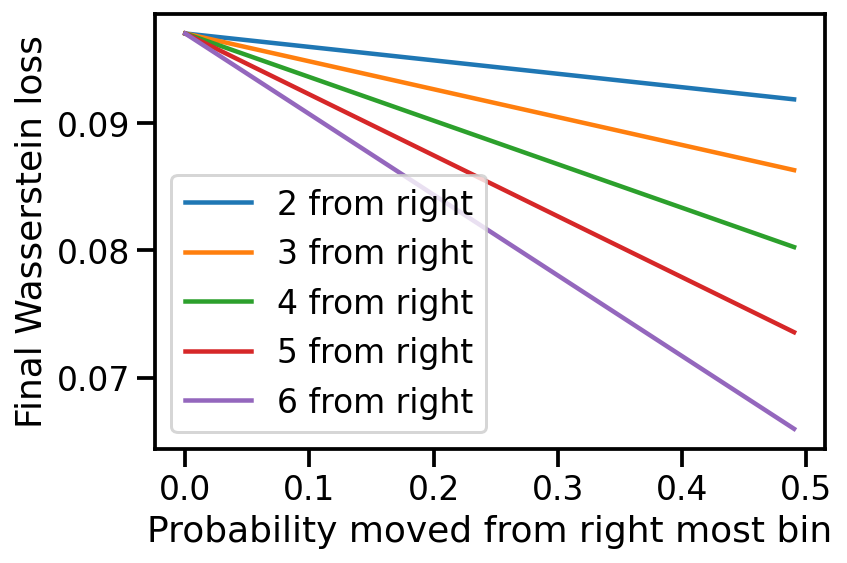

In [231]:
for b in [-2, -3, -4, -5, -6]:

    q_og = np.array([0.1, 0.3, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.5])
    amount_of_mass_to_move = q_og[-1] - q_og[b]
    update_to_q_right_most_bin = np.linspace(0.0001, amount_of_mass_to_move, 100)

    # Move mass from right most bin to bin b
    y = []
    for i in update_to_q_right_most_bin:
        q_og = np.array([0.1, 0.3, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.5])
        q_og[-1] -= i
        q_og[b] += i
        assert np.isclose(sum(q_og), 1)
        res, _ = ws_loss(p, q_og, D)
        y.append(res)

    plt.plot(update_to_q_right_most_bin, y, label=f'{np.abs(b)} from right')
    # break
plt.xlabel('Probability moved from right most bin')
plt.ylabel('Final Wasserstein loss')
plt.legend()

plt.show()

### An example of a shortcoming of Wasserstein
Let us have a true distribution p:

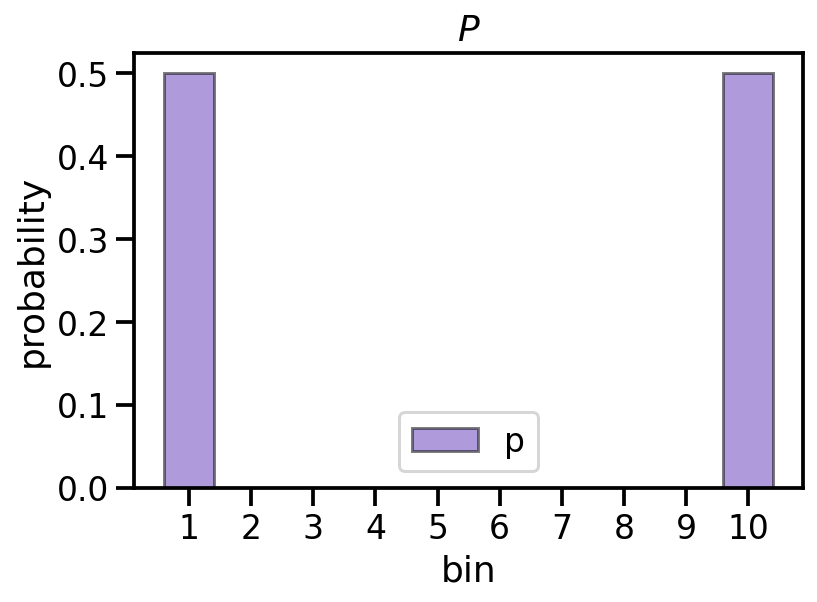

In [276]:
p = np.array([0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0.5])

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')

plt.xticks(x)
plt.title(r'$P$')
plt.xlabel('bin')
plt.ylabel('probability')
plt.legend();

We sample from $P$ and get 500 samples that look like:

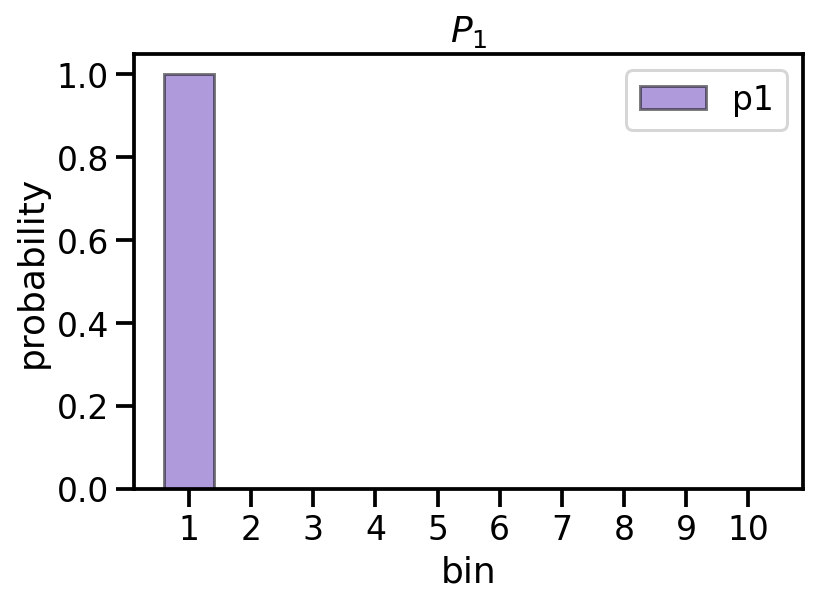

In [277]:
p1 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
p1_list = [p1] * 50

plt.bar(x=x, height=p1, alpha=0.5, label='p1', color=color1, edgecolor='black')

plt.xticks(x)
plt.title(r'$P_1$')
plt.xlabel('bin')
plt.ylabel('probability')
plt.legend();

And 500 samples that look like:

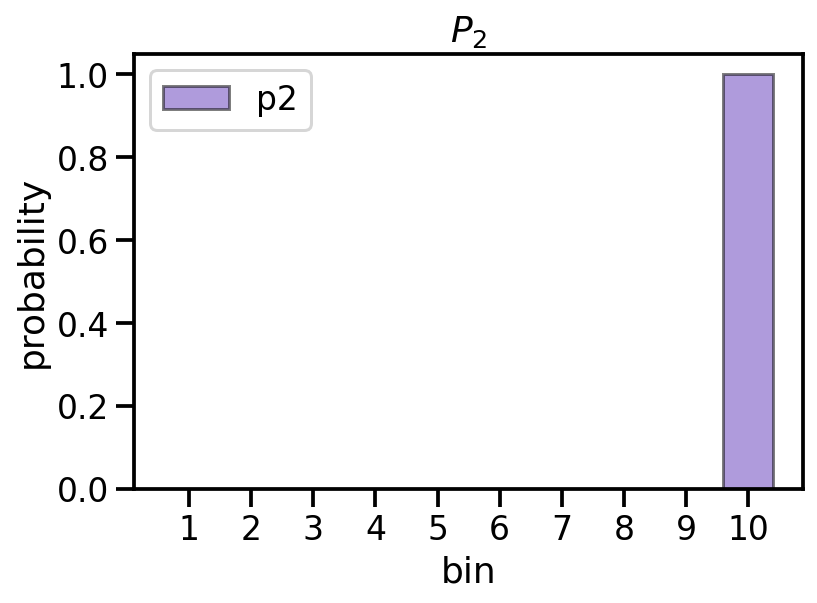

In [278]:
p2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
p2_list = [p2] * 50

plt.bar(x=x, height=p2, alpha=0.5, label='p2', color=color1, edgecolor='black')

plt.xticks(x)
plt.title(r'$P_2$')
plt.xlabel('bin')
plt.ylabel('probability')
plt.legend();

Taken as a whole, these samples yield and empirical distribution that perfectly matches the true $P$:

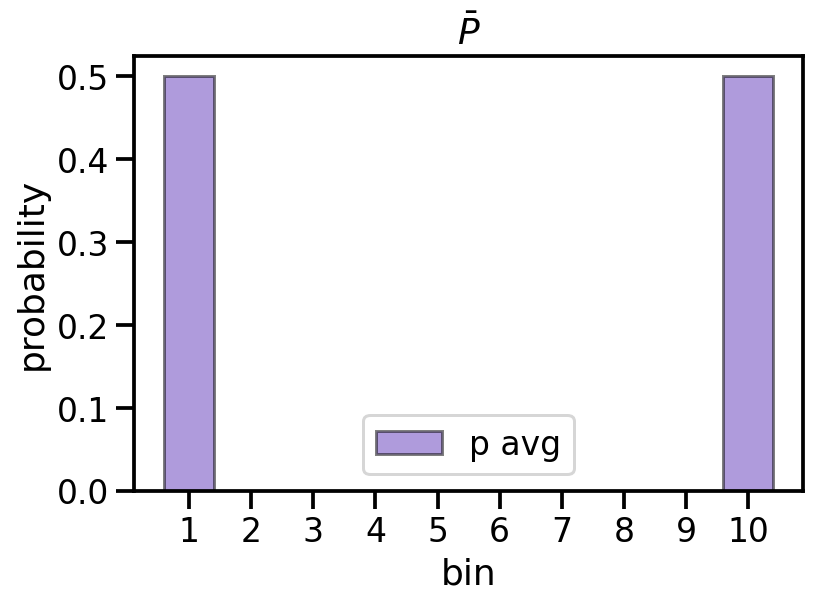

In [279]:
p_mean = np.vstack(p1_list + p2_list).mean(axis=0)

plt.bar(x=x, height=p_mean, alpha=0.5, label='p avg', color=color1, edgecolor='black')

plt.xticks(x)
plt.title(r'$\bar{P}$')
plt.xlabel('bin')
plt.ylabel('probability')
plt.legend();

Now, the question is: when generating predicted distributions $q$, what $q$ will minimize the wasserstein loss?

In [280]:
p_full_list = p1_list + p2_list

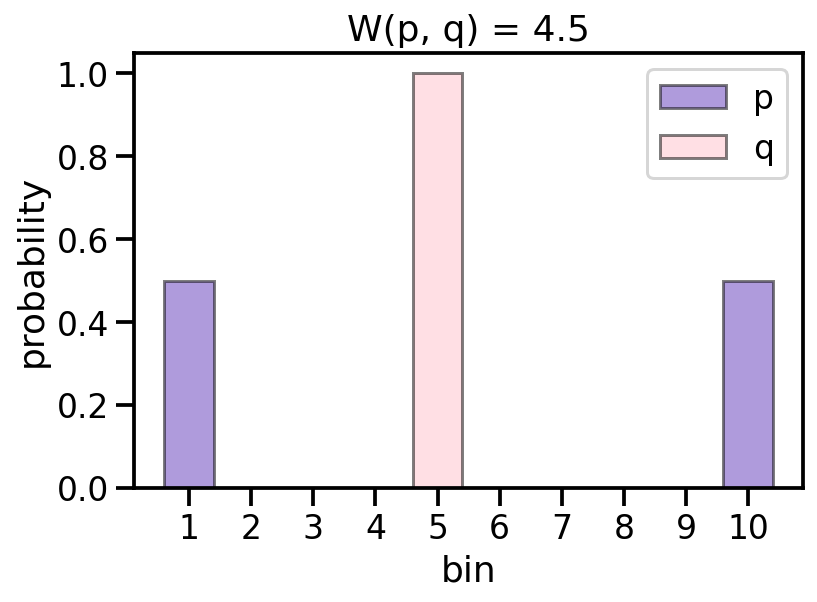

In [281]:
q_test = np.array([0.0, 0.0, 0.0, 0.0, 1, 0.0, 0.0, 0.0, 0., 0.])

assert len(p) == len(q_test)
assert np.sum(p) == 1
assert np.sum(q_test) == 1

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q_test, alpha=0.5, label='q', color=color2, edgecolor='black')

losses = []
for p_tmp in p_full_list:
    l, l_vals = ws_loss(p_tmp, q_test, D)
    losses.append(l)

total_loss = sum(losses) / len(p_full_list)

plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'W(p, q) = {total_loss}')
plt.legend();

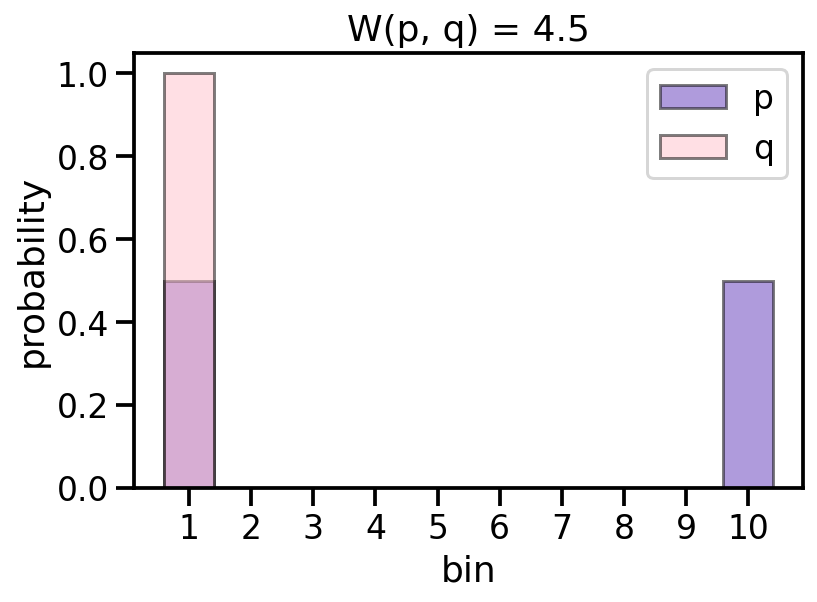

In [283]:
q_test = np.array([1, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0., 0.])

assert len(p) == len(q_test)
assert np.sum(p) == 1
assert np.sum(q_test) == 1

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q_test, alpha=0.5, label='q', color=color2, edgecolor='black')

losses = []
for p_tmp in p_full_list:
    l, l_vals = ws_loss(p_tmp, q_test, D)
    losses.append(l)

total_loss = sum(losses) / len(p_full_list)

plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'W(p, q) = {total_loss}')
plt.legend();

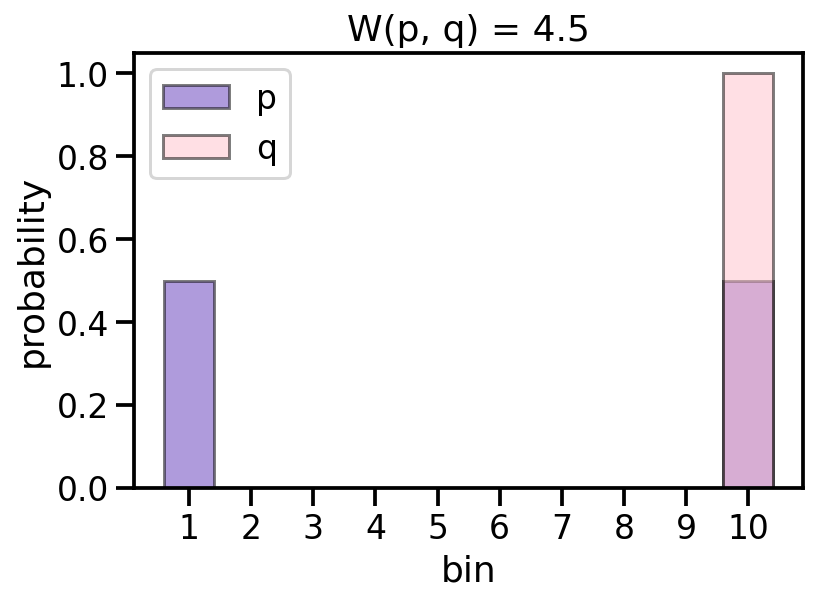

In [284]:
q_test = np.array([0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0., 1.])

assert len(p) == len(q_test)
assert np.sum(p) == 1
assert np.sum(q_test) == 1

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q_test, alpha=0.5, label='q', color=color2, edgecolor='black')

losses = []
for p_tmp in p_full_list:
    l, l_vals = ws_loss(p_tmp, q_test, D)
    losses.append(l)

total_loss = sum(losses) / len(p_full_list)

plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'W(p, q) = {total_loss}')
plt.legend();

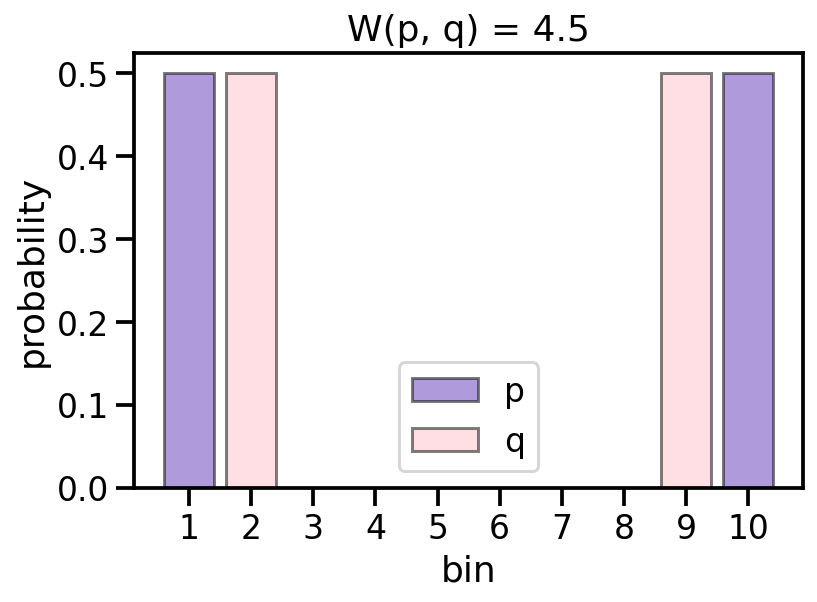

In [285]:
q_test = np.array([0, 0.5, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.5, .0])

assert len(p) == len(q_test)
assert np.sum(p) == 1
assert np.sum(q_test) == 1

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q_test, alpha=0.5, label='q', color=color2, edgecolor='black')

losses = []
for p_tmp in p_full_list:
    l, l_vals = ws_loss(p_tmp, q_test, D)
    losses.append(l)

total_loss = sum(losses) / len(p_full_list)

plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'W(p, q) = {total_loss}')
plt.legend();

We can see that _no matter the $q$ we generate_, we end up with a loss of 4.5; even when we predict the actual ground truth distribution! This is clearly not what we want.

How does cross entropy handle this scenario?

In [286]:
def safe_cross_entropy(p, q):
    return -np.nansum(p * np.log(q))

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(p * np.log(q))
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(p * np.log(q))


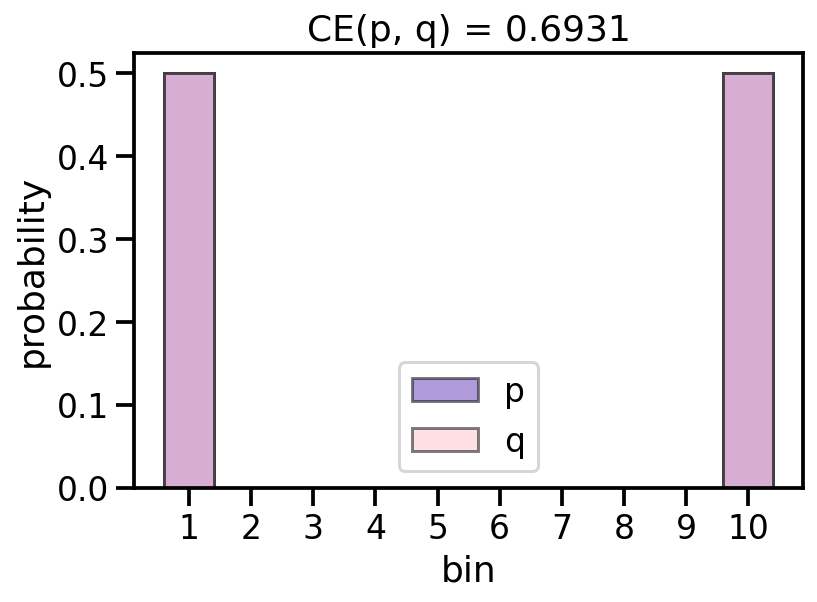

In [287]:
q_test = np.array([0.5, 0.0, 0.0, 0, 0.0, 0, 0.0, 0, 0., 0.5])

assert len(p) == len(q_test)
assert np.sum(p) == 1
assert np.sum(q_test) == 1

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q_test, alpha=0.5, label='q', color=color2, edgecolor='black')

losses = []
for p_tmp in p_full_list:
    l = safe_cross_entropy(p_tmp, q_test)
    losses.append(l)

total_loss = sum(losses) / len(p_full_list)

plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'CE(p, q) = {round(total_loss, 4)}')
plt.legend();

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(p * np.log(q))
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(p * np.log(q))


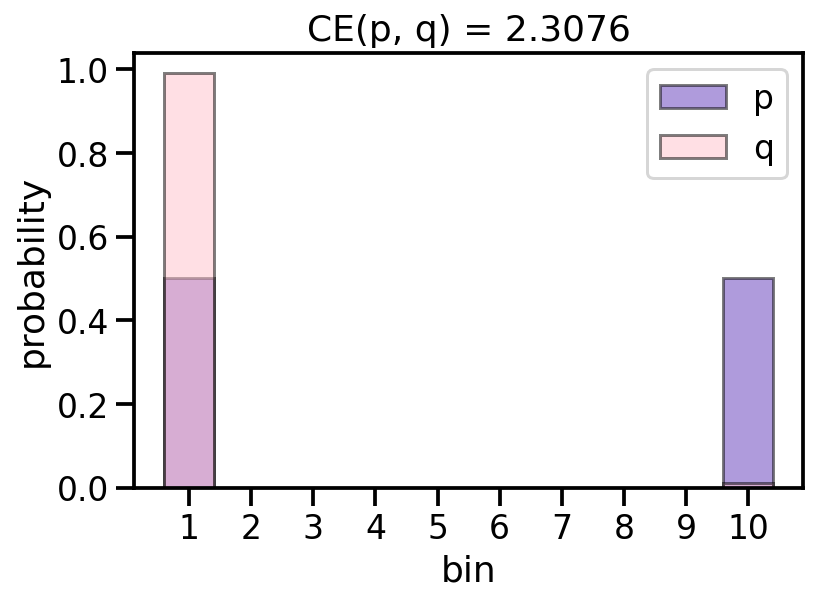

In [288]:
q_test = np.array([0.99, 0.0, 0.0, 0, 0.0, 0, 0.0, 0, 0., 0.01])

assert len(p) == len(q_test)
assert np.sum(p) == 1
assert np.sum(q_test) == 1

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q_test, alpha=0.5, label='q', color=color2, edgecolor='black')

losses = []
for p_tmp in p_full_list:
    l = safe_cross_entropy(p_tmp, q_test)
    losses.append(l)

total_loss = sum(losses) / len(p_full_list)

plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'CE(p, q) = {round(total_loss, 4)}')
plt.legend();

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(p * np.log(q))
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(p * np.log(q))


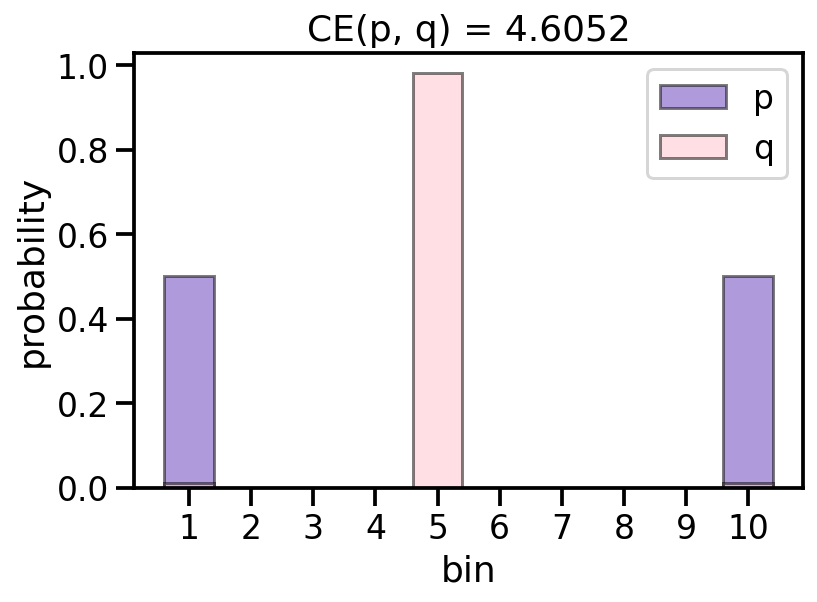

In [289]:
q_test = np.array([0.01, 0.0, 0.0, 0, 0.98, 0, 0.0, 0, 0., 0.01])

assert len(p) == len(q_test)
assert np.sum(p) == 1
assert np.sum(q_test) == 1

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q_test, alpha=0.5, label='q', color=color2, edgecolor='black')

losses = []
for p_tmp in p_full_list:
    l = safe_cross_entropy(p_tmp, q_test)
    losses.append(l)

total_loss = sum(losses) / len(p_full_list)

plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'CE(p, q) = {round(total_loss, 4)}')
plt.legend();

What about a linear combination of both?

In [290]:
def linear_combination_loss(p, q, alpha=0.5, beta=0.5):
    wl, _ = ws_loss(p, q, D)
    return alpha * safe_cross_entropy(p, q) + beta * wl 

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(p * np.log(q))
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(p * np.log(q))


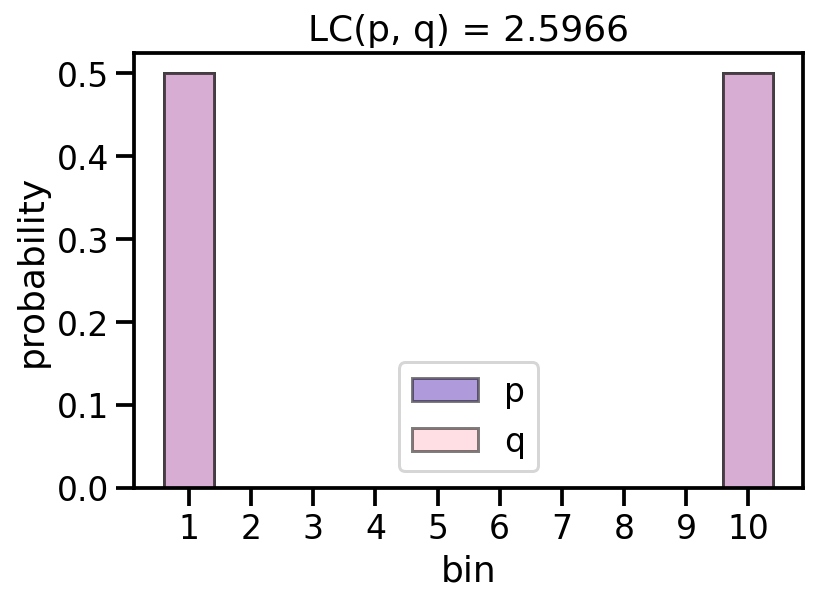

In [292]:
q_test = np.array([0.5, 0.0, 0.0, 0, 0.0, 0, 0.0, 0, 0., 0.5])

assert len(p) == len(q_test)
assert np.sum(p) == 1
assert np.sum(q_test) == 1

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q_test, alpha=0.5, label='q', color=color2, edgecolor='black')

losses = []
for p_tmp in p_full_list:
    l = linear_combination_loss(p_tmp, q_test)
    losses.append(l)

total_loss = sum(losses) / len(p_full_list)

plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'LC(p, q) = {round(total_loss, 4)}')
plt.legend();

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(p * np.log(q))
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(p * np.log(q))


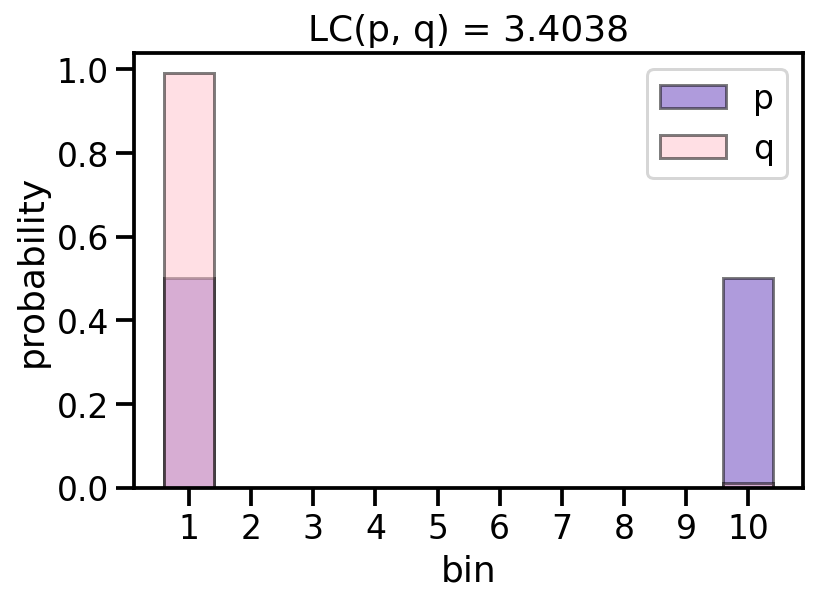

In [294]:
q_test = np.array([0.99, 0.0, 0.0, 0, 0.0, 0, 0.0, 0, 0., 0.01])

assert len(p) == len(q_test)
assert np.sum(p) == 1
assert np.sum(q_test) == 1

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q_test, alpha=0.5, label='q', color=color2, edgecolor='black')

losses = []
for p_tmp in p_full_list:
    l = linear_combination_loss(p_tmp, q_test)
    losses.append(l)

total_loss = sum(losses) / len(p_full_list)

plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'LC(p, q) = {round(total_loss, 4)}')
plt.legend();

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(p * np.log(q))
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(p * np.log(q))


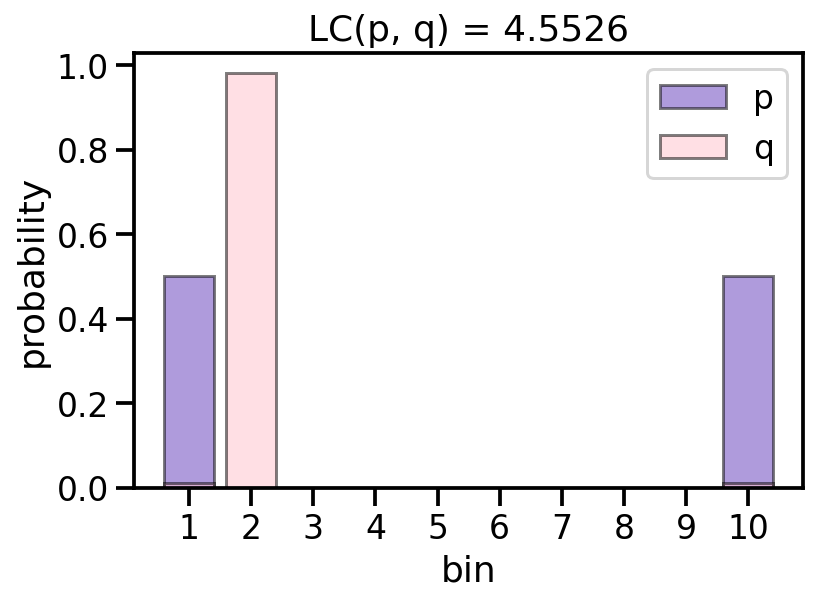

In [298]:
q_test = np.array([0.01, 0.98, 0.0, 0, 0.0, 0, 0.0, 0, 0., 0.01])

assert len(p) == len(q_test)
assert np.sum(p) == 1
assert np.sum(q_test) == 1

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q_test, alpha=0.5, label='q', color=color2, edgecolor='black')

losses = []
for p_tmp in p_full_list:
    l = linear_combination_loss(p_tmp, q_test)
    losses.append(l)

total_loss = sum(losses) / len(p_full_list)

plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'LC(p, q) = {round(total_loss, 4)}')
plt.legend();

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(p * np.log(q))
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_26573/4007411859.py:2: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(p * np.log(q))


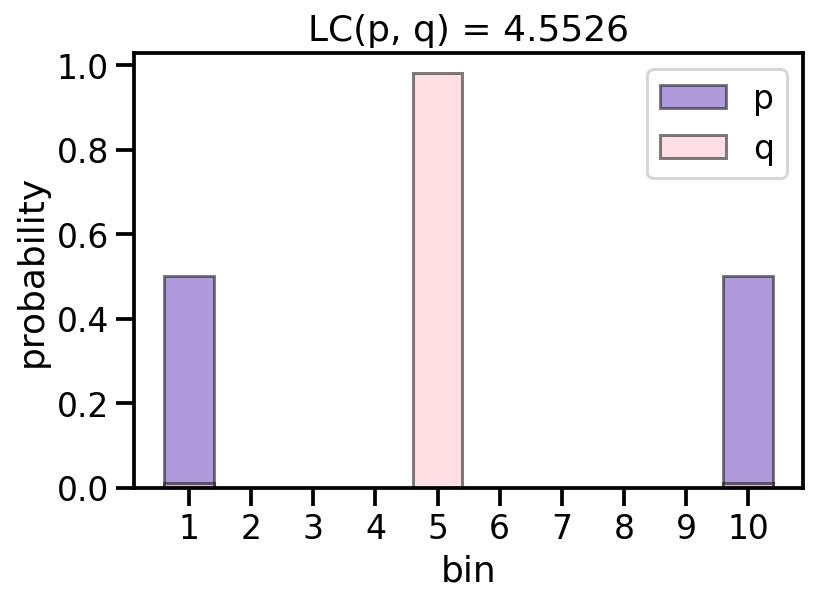

In [296]:
q_test = np.array([0.01, 0.0, 0.0, 0, 0.98, 0, 0.0, 0, 0., 0.01])

assert len(p) == len(q_test)
assert np.sum(p) == 1
assert np.sum(q_test) == 1

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q_test, alpha=0.5, label='q', color=color2, edgecolor='black')

losses = []
for p_tmp in p_full_list:
    l = linear_combination_loss(p_tmp, q_test)
    losses.append(l)

total_loss = sum(losses) / len(p_full_list)

plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'LC(p, q) = {round(total_loss, 4)}')
plt.legend();

In [220]:
p

array([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5])

In [218]:
q_test_1 = np.array([0.5, 0.0, 0.0, 0, 0.0, 0, 0.0, 0, 0., 0.5])
q_test_2 = np.array([0.0, 0.0, 0.0, 0.0, 1, 0.0, 0.0, 0.0, 0., 0.])

In [221]:
p_list = [
    np.array([1, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0., 0.]),
    np.array([0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0., 1])
]

In [233]:
def ws_loss_multiple_examples(p_list, q):
    losses = []
    for p_tmp in p_full_list:
        l, _ = ws_loss(p_tmp, q, D)
        l = np.log(l)
        losses.append(l)
    return sum(losses)

In [234]:
print('q_test_1 loss: ', ws_loss_multiple_examples(p_list, q_test_1))
print('q_test_2 loss: ', ws_loss_multiple_examples(p_list, q_test_2))

q_test_1 loss:  150.40773967762706
q_test_2 loss:  149.78661367769942


### Handling our original problem case

1.0


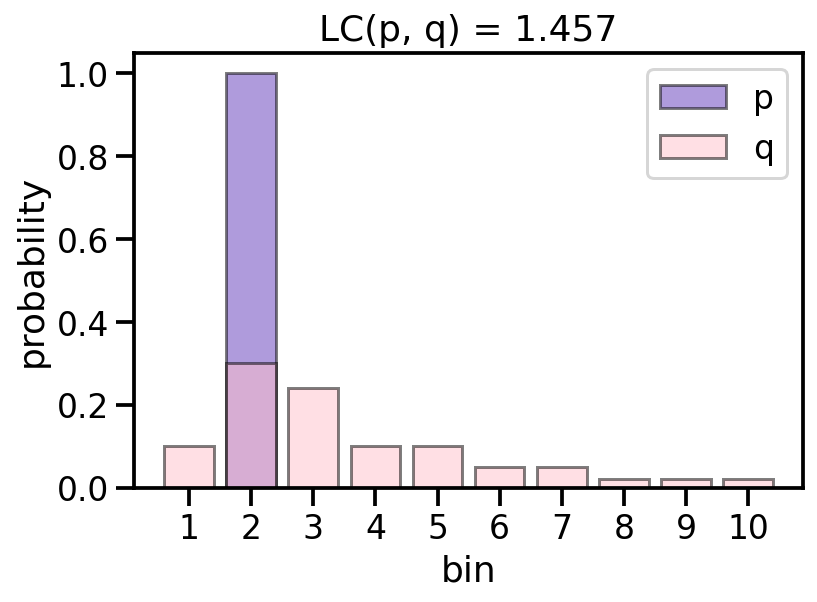

In [238]:
p = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
q1 = np.array([0.1, 0.3, 0.24, 0.1, 0.1, 0.05, 0.05, 0.02, 0.02, 0.02])

assert len(p) == len(q1)
assert np.sum(p) == 1
assert np.sum(q1) == 1

print(sum(q1))

x = np.arange(1, len(p) + 1)

plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q1, alpha=0.5, label='q', color=color2, edgecolor='black')

ce = round(linear_combination_loss(p, q1), 4)
plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'LC(p, q) = {ce}')
plt.legend();

1.0


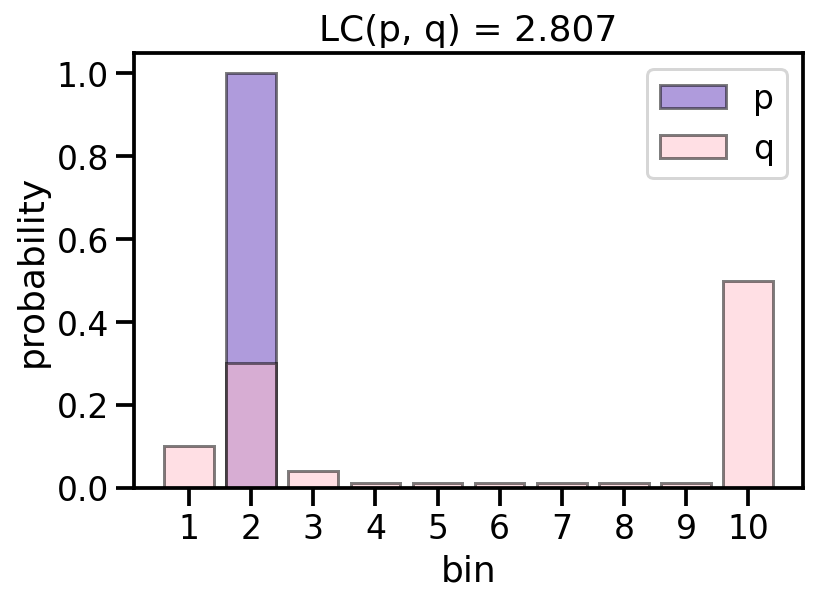

In [239]:
p = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
q2 = np.array([0.1, 0.3, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.5])

assert len(p) == len(q2)
assert np.sum(p) == 1
assert np.sum(q2) == 1

print(sum(q2))


plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
plt.bar(x=x, height=q2, alpha=0.5, label='q', color=color2, edgecolor='black')

ce = round(linear_combination_loss(p, q2), 4)
plt.xticks(x)
plt.xlabel('bin')
plt.ylabel('probability')
plt.title(f'LC(p, q) = {ce}')
plt.legend();